In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### Data Augmentation (Rotate each image to 90, 180, 270) [1 image ---> 8 images]

In [2]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, save_img

# def rotate_and_save(image, save_dir, base_name, angles):
#     for angle in angles:
#         # Rotate image using tf.image.rot90 (rotates counterclockwise by 90 degrees increments)
#         rotated_image = tf.image.rot90(image, k=angle // 90)
#         file_name = f"{base_name}_rot{angle}.png"
#         save_path = os.path.join(save_dir, file_name)
#         save_img(save_path, rotated_image)

# def augment_images(base_dir, categories, target_size=(224, 224)):
#     angles = [0, 90, 180, 270]
#     for category in categories:
#         img_dir = os.path.join(base_dir, category)
#         save_dir = os.path.join(base_dir, f"{category}_augmented")
#         os.makedirs(save_dir, exist_ok=True)
        
#         for img_name in os.listdir(img_dir):
#             if img_name.endswith('.png'):
#                 img_path = os.path.join(img_dir, img_name)
#                 img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
#                 img_array = img_to_array(img)
#                 base_name = os.path.splitext(img_name)[0]
#                 rotate_and_save(img_array, save_dir, base_name, angles)

# base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data\\clouds'
# categories = ['Healthy', 'Large Damage', 'Medium Damage', 'Minor Damage']

# augment_images(base_dir, categories)

In [3]:
base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data_aug\\clear'
#clear_dir = os.path.join(base_dir, 'clear')
#clouds_dir = os.path.join(base_dir, 'clouds')

categories = ['Healthy_augmented', 'Minor_Damage_augmented', 'Medium_Damage_augmented', 'Large_Damage_augmented']
IMG_HEIGHT = 64
IMG_WIDTH = 64

### Display some images from the clear_train_generator

In [4]:
# import matplotlib.pyplot as plt

# def plot_images(images_arr):
#     fig, axes = plt.subplots(1, 10, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Get a batch of images and labels
# sample_training_images, _ = next(clear_train_generator)
# plot_images(sample_training_images[:10])

In [5]:
def load_data(base_dir, categories, img_height, img_width):
    data = []
    labels = []
    for category in categories:
        class_num = categories.index(category)
        path = os.path.join(base_dir, category)
        for img_name in os.listdir(path):
            if img_name.endswith('.png'):
                img_path = os.path.join(path, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                data.append(img_array)
                labels.append(class_num)
    return np.array(data), np.array(labels)

data, labels = load_data(base_dir, categories, IMG_HEIGHT, IMG_WIDTH)

# Normalize the data
data /= 255.0

In [6]:
# 6048 total images
data.shape

(6048, 64, 64, 3)

In [7]:
labels.shape

(6048,)

In [8]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(categories))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(categories))

In [10]:
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training data shape: (4838, 64, 64, 3)
Validation data shape: (1210, 64, 64, 3)
Training labels shape: (4838, 4)
Validation labels shape: (1210, 4)


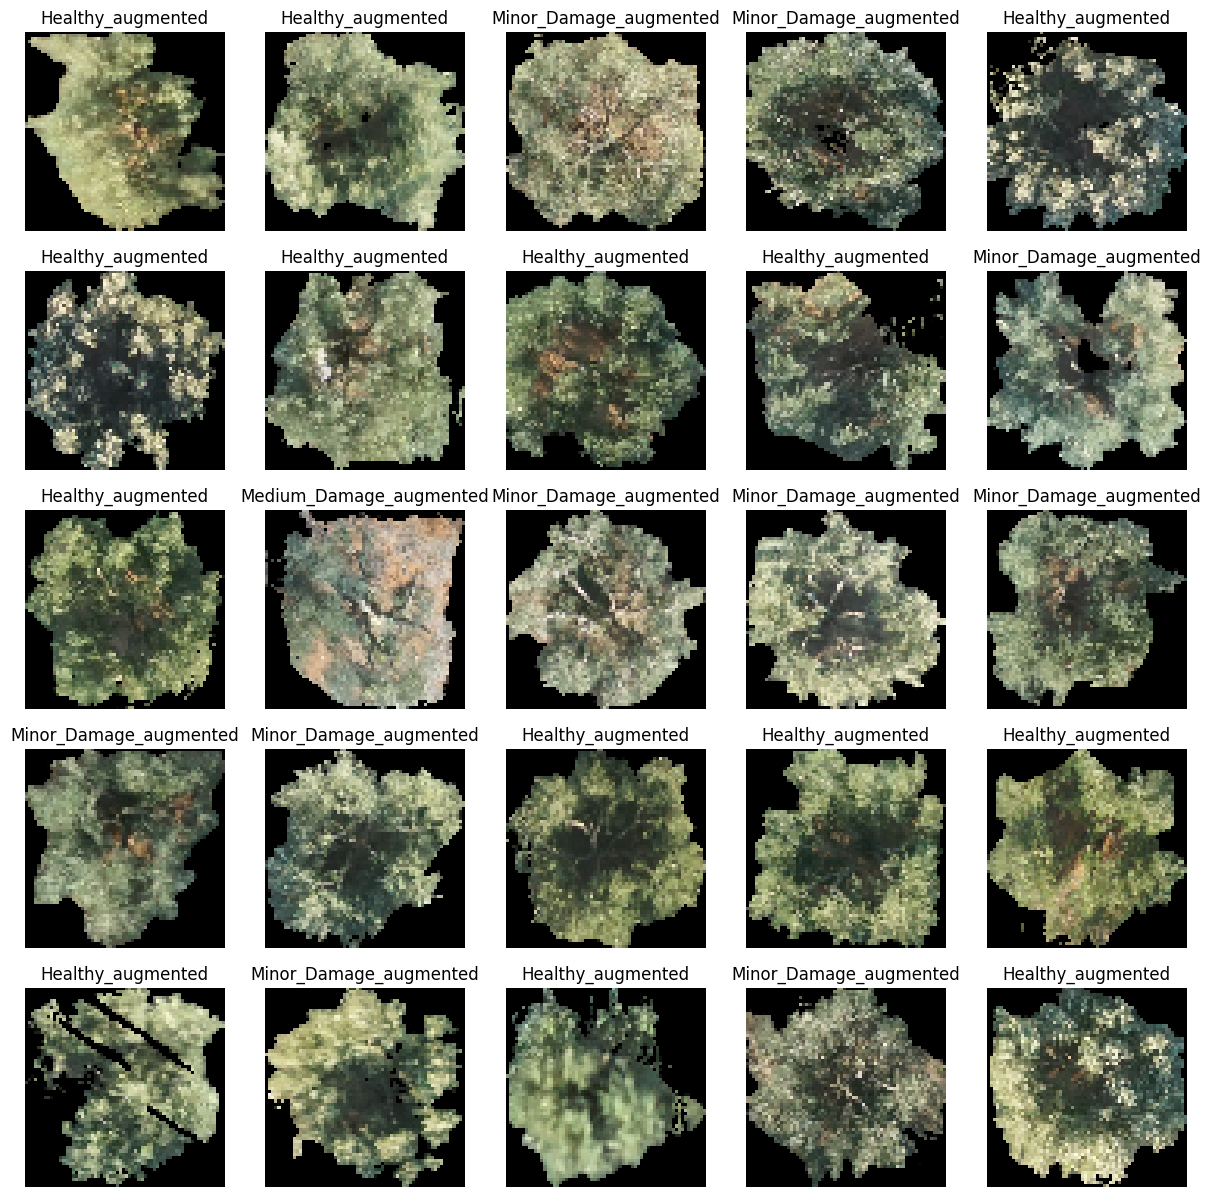

In [11]:
# Define a function to visualize images with their labels
def visualize_images(images, labels, categories, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(categories[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

# Visualize some training images with their labels
visualize_images(X_train, y_train, categories, num_images=25)

## Building the model

In [12]:
# Load the EfficientNetB7 model, without the top classification layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

258076736/258076736 [==============================] - 23s 0us/step


In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

BATCH_SIZE = 64

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
75/75 [==============================] - 74s 671ms/step - loss: 0.8413 - accuracy: 0.5203 - val_loss: 0.7825 - val_accuracy: 0.5802
Epoch 2/50
75/75 [==============================] - 41s 542ms/step - loss: 0.7937 - accuracy: 0.5559 - val_loss: 0.7824 - val_accuracy: 0.5802
Epoch 3/50
75/75 [==============================] - 40s 539ms/step - loss: 0.7837 - accuracy: 0.5568 - val_loss: 0.7755 - val_accuracy: 0.5802
Epoch 4/50
49/75 [==================>...........] - ETA: 10s - loss: 0.8099 - accuracy: 0.5357